<h1>HR analytics<a class="tocSkip"></h1>
   
<h2>Краткое описание<a class="tocSkip"></h2>

HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.

Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён. 
Собирать данные такими опросниками не так легко: компания большая, и всех сотрудников надо сначала оповестить об опросе, а затем проследить, что все его прошли. 
    
<h2>Цель проекта<a class="tocSkip"></h2>
    
Первая задача — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. 
Почему бизнесу это важно: удовлетворённость работой напрямую влияет на отток сотрудников. А предсказание оттока — одна из важнейших задач HR-аналитиков. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник.
Вторая задача — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.
    
<h2>Описание данных<a class="tocSkip"></h2> 
  
    
- `id` — уникальный идентификатор сотрудника;
- `dept` — отдел, в котором работает сотрудник;
- `level` — уровень занимаемой должности;
- `workload` — уровень загруженности сотрудника;
- `employment_years` — длительность работы в компании (в годах);
- `last_year_promo` — показывает, было ли повышение за последний год;
- `last_year_violations` — показывает, нарушал ли сотрудник трудовой договор за последний год;
- `supervisor_evaluation` — оценка качества работы сотрудника, которую дал руководитель;
- `salary` — ежемесячная зарплата сотрудника;
- `job_satisfaction_rate` — уровень удовлетворённости сотрудника работой в компании, целевой признак.
- `quit` — увольнение сотрудника из компании.    


In [1]:
!pip install matplotlib==3.5.1 -q

In [2]:
# !pip install numpy==1.22.3 -q

In [3]:
!pip install shap -q
!pip install phik -q

In [4]:
!pip install --upgrade -q scikit-learn

In [5]:
#импортируем используемые библиотеки
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots

#библиотека для расчета коэффициентов корреляции Фи
import phik
from phik import phik_matrix
from phik.report import plot_correlation_matrix

import sklearn

# для разделения выборки
from sklearn.model_selection import train_test_split

# Создание пайплайна
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# кодировщики
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder, 
    StandardScaler, 
    MinMaxScaler,
    LabelEncoder,
    RobustScaler
)

# инструмент для автоподбора гиперпараметров
from sklearn.model_selection import GridSearchCV

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# метрики
from sklearn.metrics import (
    roc_auc_score, confusion_matrix, 
    recall_score, precision_score,
    make_scorer
                            )
from sklearn.feature_selection import SelectKBest 
# импортируем модели
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC, SVR
from sklearn.dummy import DummyClassifier, DummyRegressor
# Анализ важности признаков
from sklearn.inspection import permutation_importance
import shap

In [6]:
#Константы
RANDOM_STATE = 42
TEST_SIZE = 0.25

<h2><b>Оглавление</b><a class="tocSkip"></h2>

<a href='#Step0'><b>Функции, используемые в проекте</b></a>   

<a href='#StepOne'><big><b>Задача 1. Предсказание уровня удовлетворённости сотрудника</b></big></a>  
    
<a href='#Step1'><b>1. Загрузка данных</b></a>
    
<a href='#Step2'><b>2. Предобработка данных</b></a>
- <a href='#Step2.1'><b>2.1 Исправление ошибок в данных</b></a>
- <a href='#Step2.2'><b>2.2 Проверка на явные дубликаты и пропуски</b></a>
- <a href='#Step2.3'><b>2.3 Проверка на наличие аномалий</b></a>
- <a href='#Step2.4'><b>2.4 Вывод по разделу</b></a>
    
<a href='#Step3'><b>3. Исследовательский анализ данных</b></a>
- <a href='#Step3.1'><b>3.1 Распределение данных в `train_job_satisfaction`</b></a>
- <a href='#Step3.2'><b>3.2 Распределение данных в `test_features`</b></a>
- <a href='#Step3.3'><b>3.3 Вывод по разделу</b></a>
    
<a href='#Step4'><b>4. Подготовка данных</b></a>
- <a href='#Step4.1'><b>4.1 Разделение данных на выборки</b></a>    
- <a href='#Step4.2'><b>4.2 Создание пайплайна</b></a>
- <a href='#Step4.3'><b>4.3 Создание алгоритма поиска оптимальных гиперпараметров</b></a> 
- <a href='#Step4.4'><b>4.4 Вывод по разделу</b></a>
    
<a href='#Step5'><b>5. Обучение моделей</b></a>
- <a href='#Step5.1'><b>5.1 Обучение алгоритма поиска оптимальных гиперпараметров</b></a>
- <a href='#Step5.2'><b>5.2 Проверка модели на адекватность</b></a>
- <a href='#Step5.3'><b>5.3 Вывод по разделу</b></a>

<a href='#StepTwo'><big><b>Задача 2. Предсказание увольнения сотрудника из компании</b></big></a>
    
<a href='#Step6'><b>6. Загрузка данных</b></a>

<a href='#Step7'><b>7. Предобработка данных</b></a>
- <a href='#Step7.1'><b>7.1 Исправление ошибок в данных</b></a>
- <a href='#Step7.2'><b>7.2 Проверка на явные дубликаты и пропуски</b></a>
- <a href='#Step7.3'><b>7.3 Проверка на наличие аномалий</b></a>
- <a href='#Step7.4'><b>7.4 Вывод по разделу</b></a>
    
<a href='#Step8'><b>8. Исследовательский анализ данных</b></a>
- <a href='#Step8.1'><b>8.1 Распределение данных в `train_quit` и `test_target_quit`</b></a>
- <a href='#Step8.2'><b>8.2 Вывод по распределению данных в `train_quit` и `test_target_quit`</b></a>
- <a href='#Step8.3'><b>8.3 Портрет `уволившегося сотрудника`</b></a>
- <a href='#Step8.4'><b>8.4 Вывод по разделу</b></a>    

<a href='#Step9'><b>9. Добавление нового входного признака</b></a> 
    
<a href='#Step10'><b>10. Подготовка данных</b></a>
- <a href='#Step10.1'><b>10.1 Разделение данных на выборки</b></a>    
- <a href='#Step10.2'><b>10.2 Создание пайплайна</b></a>
- <a href='#Step10.3'><b>10.3 Создание алгоритма поиска оптимальных гиперпараметров</b></a> 
- <a href='#Step10.4'><b>10.4 Вывод по разделу</b></a>
    
<a href='#Step11'><b>11. Обучение моделей</b></a>
- <a href='#Step11.1'><b>11.1 Обучение алгоритма поиска оптимальных гиперпараметров</b></a>
- <a href='#Step11.2'><b>11.2 Проверка модели на адекватность</b></a>
- <a href='#Step11.3'><b>11.3 Вывод по разделу</b></a>
    
<a href='#StepFinal'><b>Общий вывод</b></a> 

<a id='Step0'></a>
<h3><b> Функции, используемые в проекте<a class="tocSkip"></h3>

In [7]:
#Функция для отображения основной информации по датафрейму

def check_df (dataframes):
    for df in dataframes:
        df_name = [name for name, obj in globals().items() if obj is df][0]
        print(f'Общая информация по датафрейму {df_name}:')
        # общая информация
        df.info()
        # первые 5 строк
        display(df.head())
        print()

In [8]:
#Вывод уникальных значений в датафрейме

def check_unique_in_df (dataframes, types):
    for df in dataframes:
        df_name = [name for name, obj in globals().items() if obj is df][0]
        categorical_columns = [column for column in df.columns if df[column].dtype == types]
        print(f'Уникальные значения в датафрейме {df_name}:')
        for column in categorical_columns:
            print(f'Столбец {column}: {df[column].unique()}')
        print()

In [9]:
#Функция переименования значений столбцов:

def replace_name (df, column, name, new_name):
    df[column] = df[column].replace({name: new_name})
    return print(df[column].unique())

In [10]:
#Функция переименования столбцов:

def columns_remove_spaces(dataframes):
    for df in dataframes:
        df.columns = df.columns.str.replace(' ', '_').str.lower()

In [11]:
#Функция проверки на пропущенные значения и явные дубликаты

def check_isna_dupl (dataframes):
    for df in dataframes:
        df_name = [name for name, obj in globals().items() if obj is df][0]
        print(f'В датафрейме {df_name}:')
        print(f'Количество пропущенных значений:\n{df.isna().sum()} \
        \nКоличество явных дубликатов: {df.duplicated().sum()}')
        print()

In [12]:
#Функция построения графика распределения признаков

def categoral_unique(df, col, target):   
    plt.figure(figsize=(8,6))
    plot = sns.countplot(y=col, data=df, hue=target)
    plot.set_title(f'Рапределение по {col}', fontsize=16)
    plot.set_xlabel('Количество', fontsize=14)

In [13]:
#Функция построения графика гистограмм распределения

def histogram(df, col, target):
    sns.histplot(df, bins=20, kde=True, hue=target, x=col)
    plot.set_title(f'Рапределение по {col}', fontsize=16)
    plot.set_ylabel('Количество', fontsize=14)

<a id='StepOne'></a>
# Задача 1. Предсказание уровня удовлетворённости сотрудника

<a id='Step1'></a>
## Загрузка данных

In [14]:
train_job_satisfaction = pd.read_csv('https://code.s3.yandex.net/datasets/train_job_satisfaction_rate.csv')
test_features = pd.read_csv('https://code.s3.yandex.net/datasets/test_features.csv')
test_target_job_satisfaction_rate = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_job_satisfaction_rate.csv')

In [15]:
check_df([train_job_satisfaction, test_features, test_target_job_satisfaction_rate])

Общая информация по датафрейму train_job_satisfaction:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20



Общая информация по датафрейму test_features:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800



Общая информация по датафрейму test_target_job_satisfaction_rate:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


In [16]:
check_unique_in_df([train_job_satisfaction, test_features, test_target_job_satisfaction_rate], 'object')

Уникальные значения в датафрейме train_job_satisfaction:
Столбец dept: ['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
Столбец level: ['junior' 'middle' 'sinior' nan]
Столбец workload: ['medium' 'high' 'low']
Столбец last_year_promo: ['no' 'yes']
Столбец last_year_violations: ['no' 'yes']

Уникальные значения в датафрейме test_features:
Столбец dept: ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
Столбец level: ['junior' 'middle' 'sinior' nan]
Столбец workload: ['medium' 'low' 'high' ' ']
Столбец last_year_promo: ['no' 'yes']
Столбец last_year_violations: ['no' 'yes']

Уникальные значения в датафрейме test_target_job_satisfaction_rate:



**Первичный осмотр**

1. Загружено 3 датафрейма
2. В `train_job_satisfaction` присутствуют пропущенные значения в столбцах `dept`, `level`. 
3. В `test_features` присутствуют пропущенные значения в столбцах `dept`, `level`. 
4. Типы данных во всех датафреймах соответствуют содержанию стобцов.
5. В `train_job_satisfaction` в столбце `level` опечатка в `sinior`
6. В `test_features` в столбце `level` опечатка в `sinior`
7. В `test_features` в столбце `workload` есть значения `    ` (пробел) в некоторых строках

<a id='Step2'></a>
##  Предобработка данных

<a id='Step2.1'></a>
###  Исправление ошибок в данных

В предыдущем шаге обнаружили опечатки в признаковом описании данных. Исправим на соответствующие. А также уберем значения пробела на самое встречаемое

In [17]:
replace_name(train_job_satisfaction, 'level', 'sinior', 'senior')
replace_name(test_features, 'level', 'sinior', 'senior')
#replace_name(test_features, 'dept', ' ', 'sales')
#replace_name(test_features, 'workload', ' ', 'medium')

['junior' 'middle' 'senior' nan]
['junior' 'middle' 'senior' nan]


<a id='Step2.2'></a>
###  Проверка на явные дубликаты и пропуски

In [18]:
check_isna_dupl([train_job_satisfaction, test_features, test_target_job_satisfaction_rate])

В датафрейме train_job_satisfaction:
Количество пропущенных значений:
id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64         
Количество явных дубликатов: 0

В датафрейме test_features:
Количество пропущенных значений:
id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64         
Количество явных дубликатов: 0

В датафрейме test_target_job_satisfaction_rate:
Количество пропущенных значений:
id                       0
job_satisfaction_rate    0
dtype: int64         
Количество явных дубликатов: 0



**Пропущенные значения в столбцах `dept` и `level` уберем на стадии создании пайплайна**

In [19]:
train_job_satisfaction[train_job_satisfaction['dept'].isna()]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1526,694746,NaN,junior,medium,5,no,no,4,21600,0.62
1630,814624,NaN,junior,medium,3,no,no,4,24000,0.88
1633,475114,NaN,junior,high,4,no,no,4,31200,0.63
2781,497243,NaN,junior,medium,1,no,no,3,26400,0.28
2975,168668,NaN,junior,low,3,no,no,4,18000,0.88
3866,641150,NaN,junior,low,3,no,yes,4,12000,0.54


In [20]:
train_job_satisfaction[train_job_satisfaction['level'].isna()]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1209,631073,sales,NaN,medium,1,no,no,4,27600,0.66
1469,416327,sales,NaN,low,1,no,no,5,18000,0.73
1745,135043,sales,NaN,medium,1,no,no,3,26400,0.30
2522,998838,sales,NaN,medium,1,no,no,5,27600,0.71


<a id='Step2.3'></a>
###  Проверка на наличие аномалий

Воспользуемся описательной статистикой

In [21]:
display(train_job_satisfaction.describe())
display(test_features.describe())
test_target_job_satisfaction_rate.describe()

,id,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,544957.621000,3.718500,3.476500,33926.700000,0.533995
std,257883.104622,2.542513,1.008812,14900.703838,0.225327
min,100954.000000,1.000000,1.000000,12000.000000,0.030000
25%,322836.750000,2.000000,3.000000,22800.000000,0.360000
50%,534082.500000,3.000000,4.000000,30000.000000,0.560000
75%,771446.000000,6.000000,4.000000,43200.000000,0.710000
max,999521.000000,10.000000,5.000000,98400.000000,1.000000


,id,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000,2000.000000
mean,552765.213500,3.666500,3.526500,34066.800000
std,253851.326129,2.537222,0.996892,15398.436729
min,100298.000000,1.000000,1.000000,12000.000000
25%,339052.000000,1.000000,3.000000,22800.000000
50%,550793.000000,3.000000,4.000000,30000.000000
75%,765763.750000,6.000000,4.000000,43200.000000
max,999029.000000,10.000000,5.000000,96000.000000


,id,job_satisfaction_rate
count,2000.000000,2000.00000
mean,552765.213500,0.54878
std,253851.326129,0.22011
min,100298.000000,0.03000
25%,339052.000000,0.38000
50%,550793.000000,0.58000
75%,765763.750000,0.72000
max,999029.000000,1.00000


<a id='Step2.4'></a>
###  Вывод по разделу

- Убрали опечатки в `train_job_satisfaction` и `test_features`.
- Заменили `пробелы` как опечатки на самые встречаемые значения.
- Обнаружили пропущенные значения в датафреймах, которые дальше уберем при построении пайплайна.
- Явных дубликатов не обнаружено
- Аномалий в данных не обнаружили.
- Выбросами считаем разбег значений по столбцу `salary` - подберем такую модель и кодировщик, которые не будут учитывать их

<a id='Step3'></a>
##  Исследовательский анализ данных

**Исследуем все признаки и сделаем выводы о том, как их нужно подготовить.**

<a id='Step3.1'></a>
###  Распределение данных в `train_job_satisfaction`

**Построим распределение непрерывных количественных признаков - входного и целевого**

Для анализа распределения **непрерывного признака** в разрезе целевого будем использовать нормированную гистограмму ( sns.histplot() с параметрами stat=`density`, common_norm=False или sns.kdeplot()): гистограммы такого типа позволяют нивелировать разницу в размерах выборок при анализе распределений.

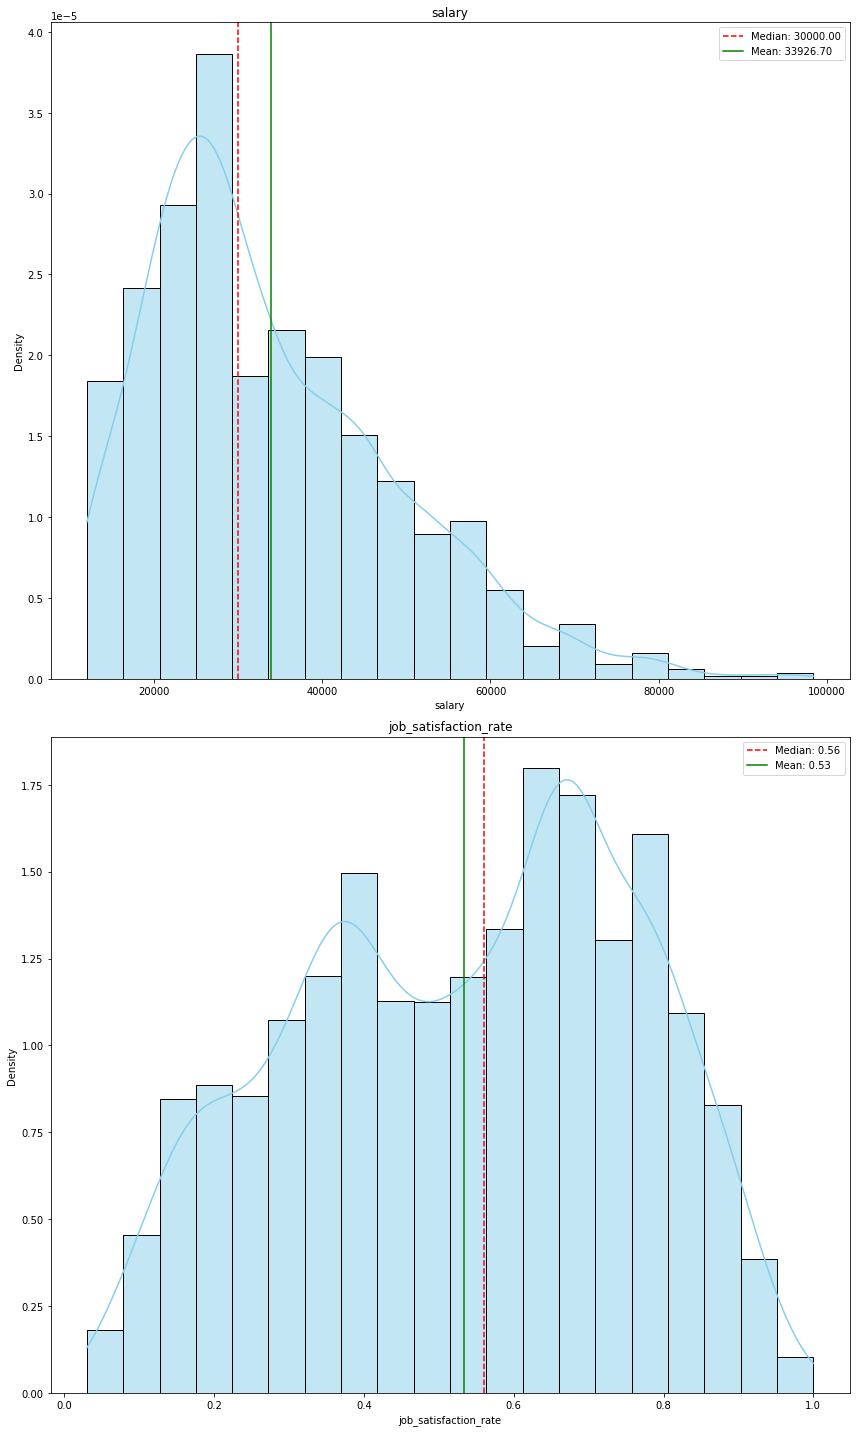

In [22]:
# Создание графика с 8 подграфиками в два столбца
fig, axes = plt.subplots(2, 1, figsize=(12, 20))

# Преобразование 2D массива подграфиков в 1D для удобного индексирования
axes = axes.ravel()

# Построение гистограммы с ядерной оценкой плотности для каждого столбца
for i, column in enumerate([
    'salary', 'job_satisfaction_rate'
]):
    sns.histplot(data=train_job_satisfaction, bins=20, kde=True, ax=axes[i], 
                 x=column, stat='density', common_norm=False, color='skyblue')
    axes[i].set_title(column)
    
    # Добавление медианы и среднего значения
    median_value = train_job_satisfaction[column].median()
    mean_value = train_job_satisfaction[column].mean()
    axes[i].axvline(median_value, color='r', linestyle='--', label=f'Median: {median_value:.2f}')
    axes[i].axvline(mean_value, color='g', linestyle='-', label=f'Mean: {mean_value:.2f}')
    axes[i].legend()
    axes[0].legend(loc='upper right')

# Показать графики
plt.tight_layout()
plt.show();

**Построим распределение дискретных признаков**

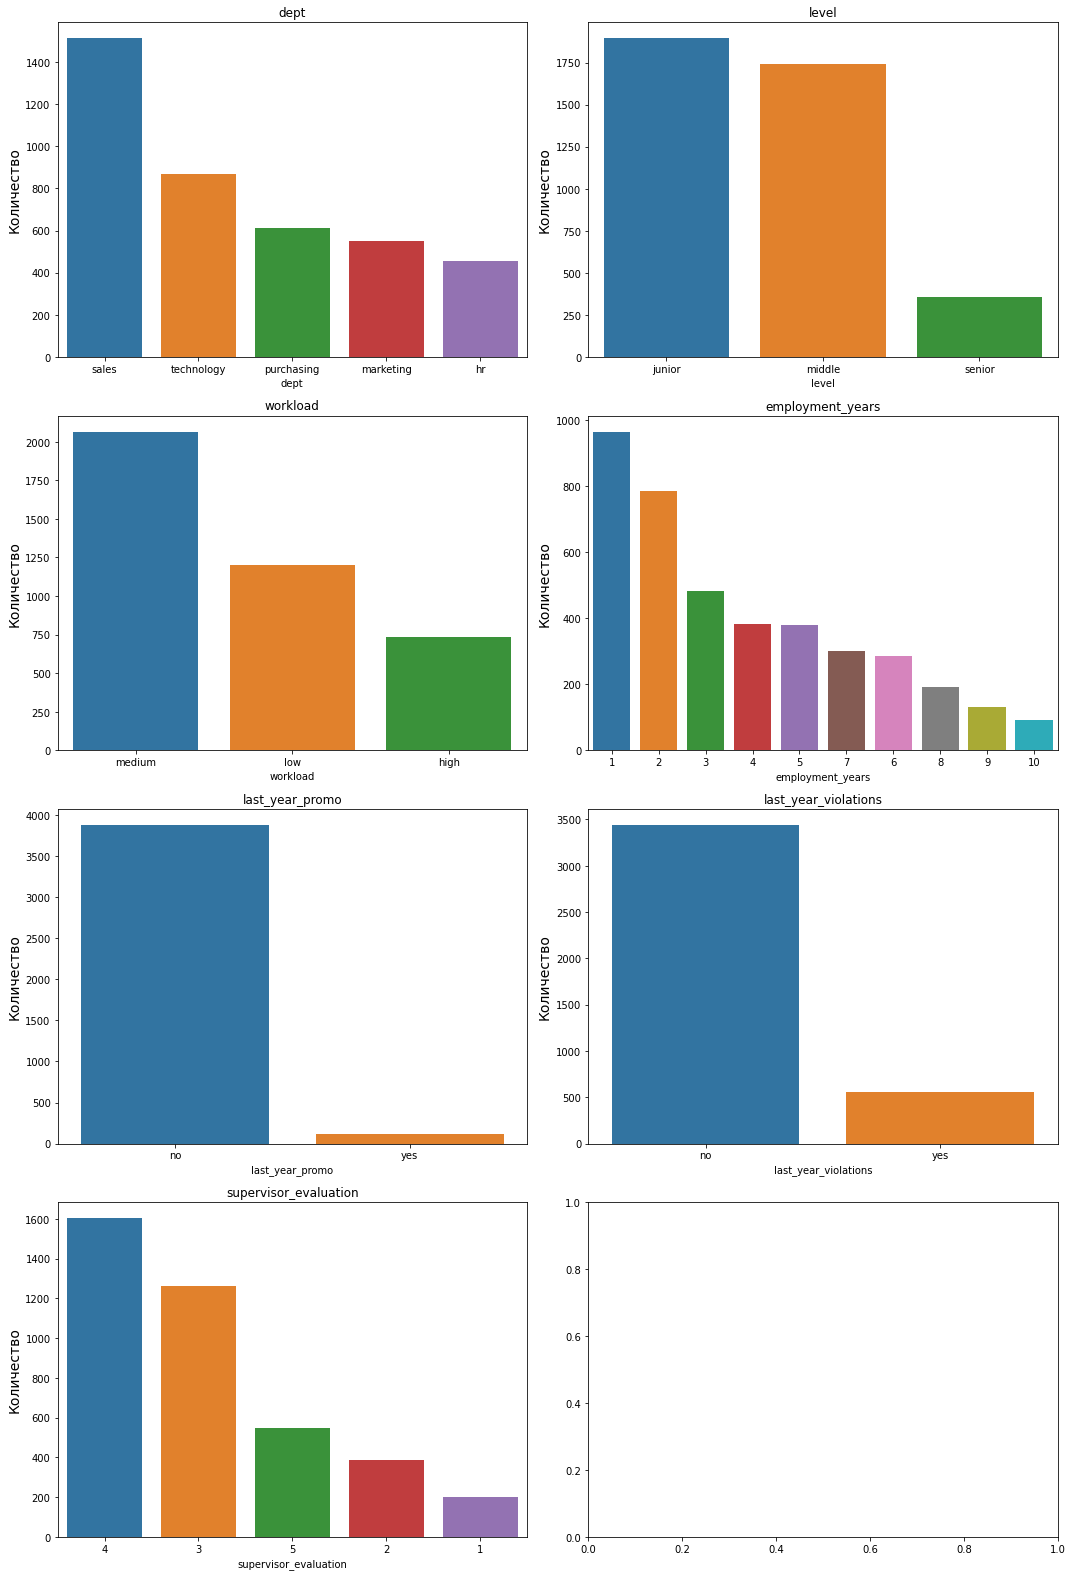

In [23]:
# Создание графика с 8 подграфиками в два столбца
fig, axes = plt.subplots(4, 2, figsize=(15, 22))

# Преобразование 2D массива подграфиков в 1D для удобного индексирования
axes = axes.ravel()

# Построение гистограмм
for i, column in enumerate([
    'dept', 'level',
    'workload', 'employment_years',
    'last_year_promo', 'last_year_violations',
    'supervisor_evaluation'
]):
    sns.countplot(data=train_job_satisfaction, ax=axes[i], 
                 x=column, order = train_job_satisfaction[column].value_counts().index)
    axes[i].set_title(column)
    axes[i].set_ylabel('Количество', fontsize=14)
    #axes[i].legend()
    #axes[i].legend(loc='upper right')   
    
# Показать графики
plt.tight_layout()
plt.show();

**Вывод по распределениям признаков в `train_job_satisfaction`**

- В исследуемых данных два непрерывных признака `salary` и `job_satisfaction_rate`. Для них построили нормализованные гистограммы распределения значений.
    1. Распределение зарплат стремится к нормальному, со смещением влево и уменьшением плотности сотрудников по мере увеличения зарплаты. **Аномалий не обнаружено, но присутствуют выбросы - очень много сотрудников на младших позициях имеют низкую зарплату в районе `30000`, и только небольшая часть опытных работников на позициях `senior` получают зарплату до `80000`**
    2. Медианная зарплата `30000` и средняя `33926.7`
    3. Распределение удовлетворенности близко к нормальному со средним `0.53` и медианой `0.56`
    4. Проблем с количественных признаков не обнаружено.
    
    
- Распределение дискретных признаков построили при помощи `countplot()`
    1. Наблюдается дисбаланс во всех дискретных признаках.
    2. Сотрудников, работающих в отделе `dept` больше всего, в остальных отделах примерно в половину меньше.
    3. Больше всего сотрудников работает на позициях `junior` и `middle`. 
    4. В основном у сотрудников `medium` уровень загруженности сотрудника. Примерно в три раза меньше сотрудников имеют уровень загруженности `high`.
    5. В компании очень много новых сотрудников. Преимущественно стаж работы в компании у сотрудников `от 1 до 3 лет`. Скорее всего присутствует сильная текучка кадров.
    6. Сильный перекос во входных признаках `last_year_promo` и `last_year_violations` - сотрудники не получают повышение, но также и не получают штрафы.
    7. Руководители в основном оценивают сотрудников оценкой `4` и меньше всего ставят `1`.

<a id='Step3.2'></a>
###  Распределение данных в `test_features`

**Построим распределение непрерывных количественного признака**

Чтобы построить распределение признаков из тестовой выборки для удобства объединим выборку с входными признаками и целевым признаком в одну `test_features_total`.

Расположение строк с `id` в `test_features` и `test_target_job_satisfaction_rate` не соответствуют друг другу - для этого после объединения уберем целевой признак и перезапишем `test_features`.

In [24]:
test_features_total = test_features.merge(test_target_job_satisfaction_rate, how= 'left', on = 'id')
test_features = test_features_total.drop('job_satisfaction_rate', axis= 1)

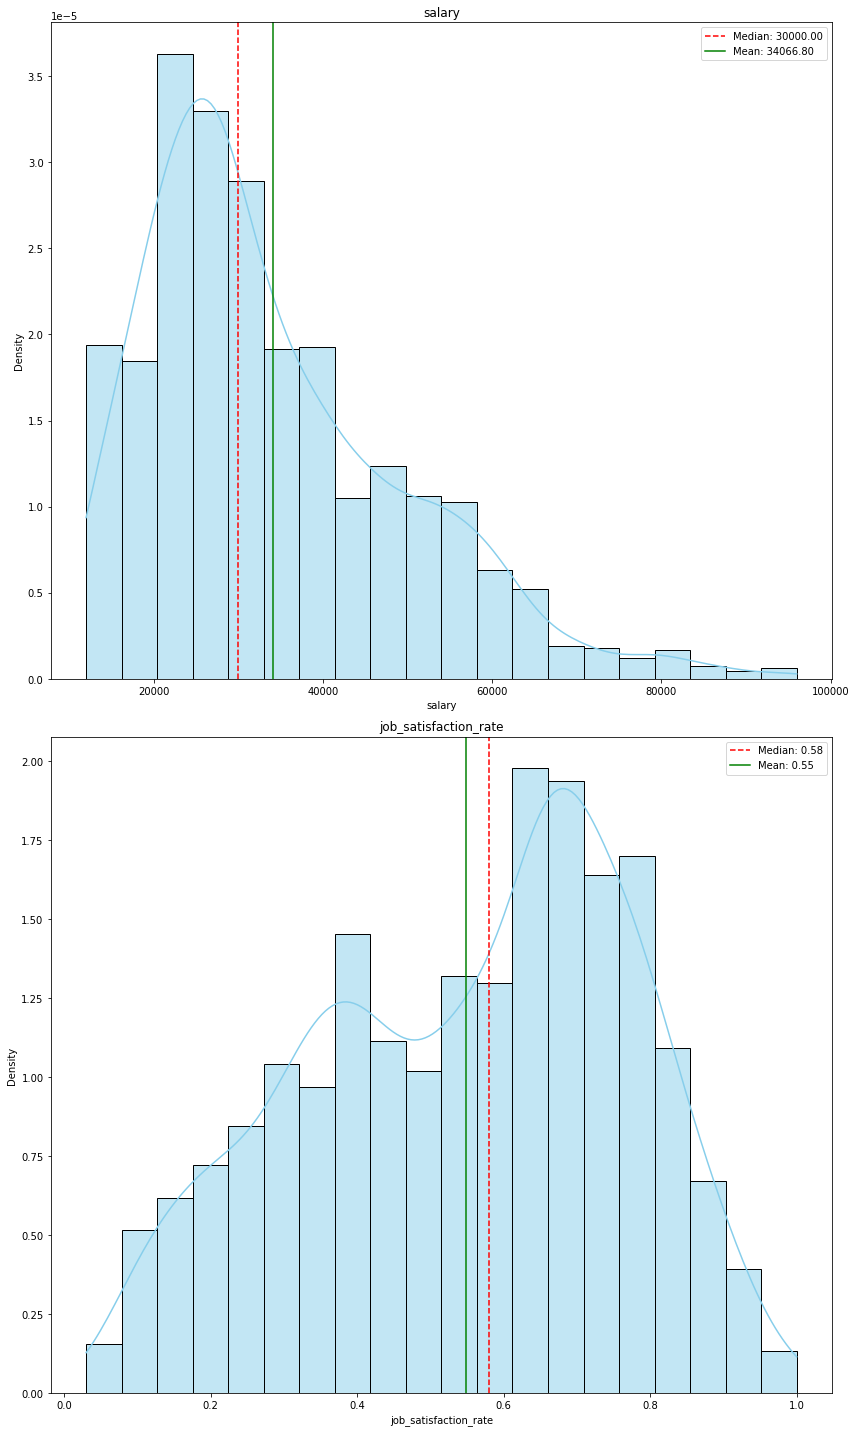

In [25]:
# Создание графика с 8 подграфиками в два столбца
fig, axes = plt.subplots(2, 1, figsize=(12, 20))

# Преобразование 2D массива подграфиков в 1D для удобного индексирования
axes = axes.ravel()

# Построение гистограммы с ядерной оценкой плотности для каждого столбца
for i, column in enumerate([
    'salary', 'job_satisfaction_rate'
]):
    sns.histplot(data=test_features_total, bins=20, kde=True, ax=axes[i], 
                 x=column, stat='density', common_norm=False, color='skyblue')
    axes[i].set_title(column)
    
    # Добавление медианы и среднего значения
    median_value = test_features_total[column].median()
    mean_value = test_features_total[column].mean()
    axes[i].axvline(median_value, color='r', linestyle='--', label=f'Median: {median_value:.2f}')
    axes[i].axvline(mean_value, color='g', linestyle='-', label=f'Mean: {mean_value:.2f}')
    axes[i].legend()
    axes[0].legend(loc='upper right')

# Показать графики
plt.tight_layout()
plt.show();

**Построим распределение дискретных признаков**

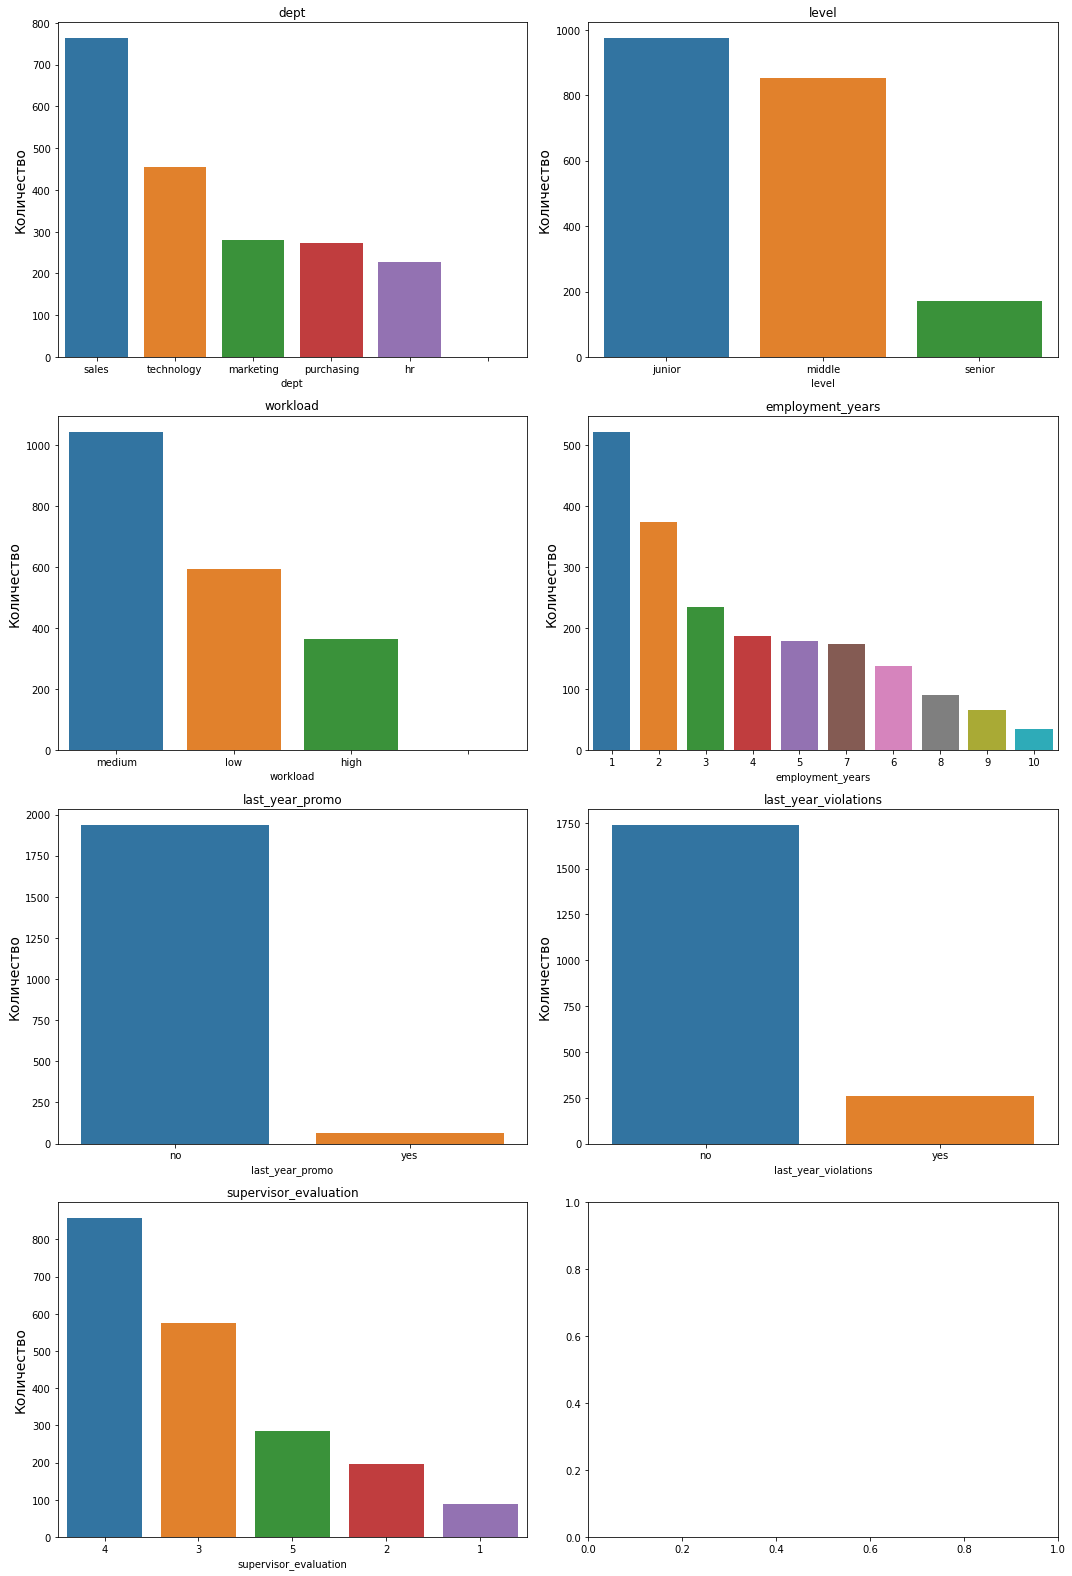

In [26]:
# Создание графика с 8 подграфиками в два столбца
fig, axes = plt.subplots(4, 2, figsize=(15, 22))

# Преобразование 2D массива подграфиков в 1D для удобного индексирования
axes = axes.ravel()

# Построение гистограмм
for i, column in enumerate([
    'dept', 'level',
    'workload', 'employment_years',
    'last_year_promo', 'last_year_violations',
    'supervisor_evaluation'
]):
    sns.countplot(data=test_features_total, ax=axes[i], 
                 x=column, order = test_features_total[column].value_counts().index)
    axes[i].set_title(column)
    axes[i].set_ylabel('Количество', fontsize=14)
    #axes[i].legend()
    #axes[i].legend(loc='upper right')   
    
# Показать графики
plt.tight_layout()
plt.show();

**Вывод по распределениям признаков в `test_features`**

- Два непрерывных признака `salary` и `job_satisfaction_rate`:

    1. Распределение зарплат стремится к нормальному, со смещением влево и уменьшением плотности сотрудников по мере увеличения зарплаты. **Аномалий не обнаружено, но присутствуют выбросы - очень много сотрудников на младших позициях имеют низкую зарплату в районе `30000`, и только небольшая часть опытных работников на позициях `senior` получают зарплату до `80000`**
    2. Медианная зарплата `30000` и средняя `34066.8`
    3. Распределение удовлетворенности близко к нормальному со средним `0.55` и медианой `0.58`
    4. Проблем с количественных признаков не обнаружено.
    
    
- Распределение дискретных признаков построили при помощи `countplot()`

    **Дискретные признаки в тестовой выборке распределены также как в тренировочной выборке.**

In [27]:
train_job_satisfaction.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [28]:
interval_cols = ['salary', 'job_satisfaction_rate']

In [29]:
f_corr_matr = train_job_satisfaction.drop(columns=['id']).phik_matrix(interval_cols=interval_cols)
f_corr_matr

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
dept,1.000000,0.000000,0.016509,0.037853,0.000000,0.000000,0.105495,0.282265,0.082086
level,0.000000,1.000000,0.419114,0.682773,0.101613,0.000000,0.000000,0.717630,0.080620
workload,0.016509,0.419114,1.000000,0.181941,0.058663,0.000000,0.037023,0.788820,0.056128
employment_years,0.037853,0.682773,0.181941,1.000000,0.183579,0.056808,0.000000,0.483419,0.325603
last_year_promo,0.000000,0.101613,0.058663,0.183579,1.000000,0.000000,0.013681,0.215025,0.190803
last_year_violations,0.000000,0.000000,0.000000,0.056808,0.000000,1.000000,0.182042,0.010078,0.560348
supervisor_evaluation,0.105495,0.000000,0.037023,0.000000,0.013681,0.182042,1.000000,0.000000,0.764364
salary,0.282265,0.717630,0.788820,0.483419,0.215025,0.010078,0.000000,1.000000,0.165830
job_satisfaction_rate,0.082086,0.080620,0.056128,0.325603,0.190803,0.560348,0.764364,0.165830,1.000000


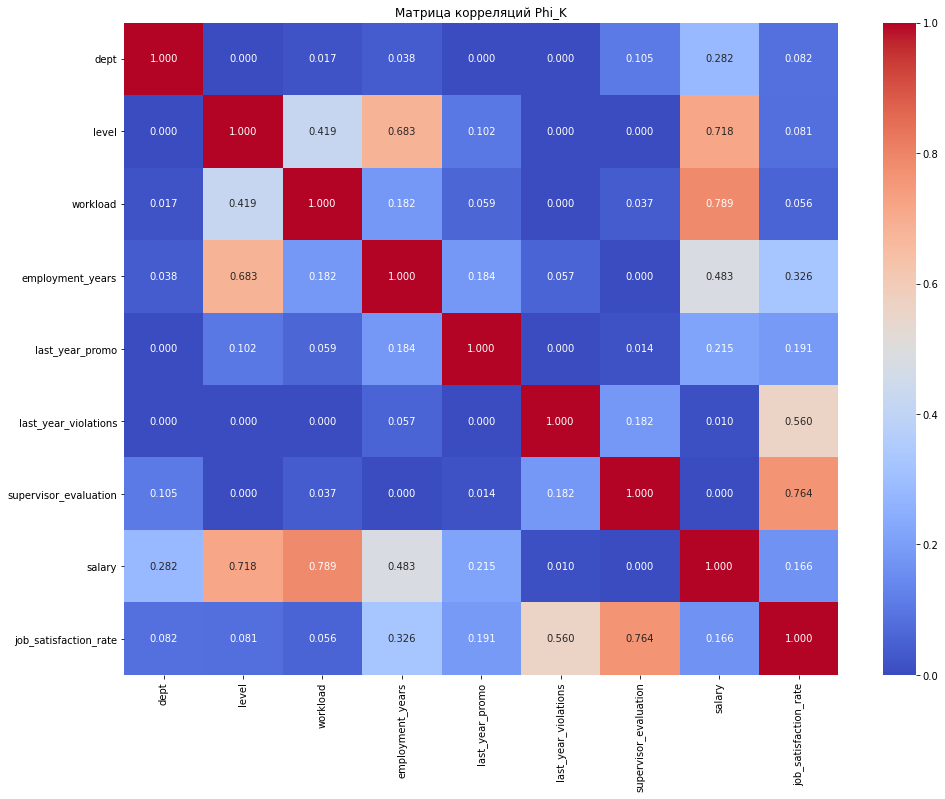

In [30]:
#Построение тепловой карты методом sns.heatmap()
plt.figure(figsize=(16, 12))
sns.heatmap(f_corr_matr, annot=True, cmap='coolwarm', fmt='.3f')
#plt.xticks(rotation=45)
plt.title('Матрица корреляций Phi_K')
plt.show()

Шкала Чеддока используется для оценки силы связи коэффициентов корреляции - другими словами величина коэффициента корреляции показывает силу связи. Используется следующая таблица для оценки силы связи:

- 0 - 0.3 - очень слабая
- 0.3 - 0.5 - слабая
- 0.5 - 0.7 - средняя
- 0.7 - 0.9 - высокая
- 0.9 - 1 - очень высокая

Из-за мультиколлинеарности коэффициенты модели могут стать неустойчивыми и в целом скажется на работе моделей. Сложнее будет интерпретировать ее.

- Высокую корреляцию имеют между собой пары входных признаков `salary` и `level`, `salary` и `workload`
- Логично, что коррелируют между собой `employment_years` и `level` - чем больше стажа - тем выше должность.
- С целевым признаком имеет высокую корреляцию `Оценка руководителя`, а также `last_year_violations`. Тут тоже все логично, что оценка руководителя и наличие нарушений влияют на целевой признак.

<a id='Step3.3'></a>
###  Вывод по разделу

**1. По итогам построения графиков**

- В исследуемых данных два непрерывных признака `salary` и `job_satisfaction_rate`. Для них построили нормализованные гистограммы распределения значений. Имеют близкое к нормальному распределению - проблем и аномалий не обнаружено.
- Распределение дискретных признаков построили при помощи `countplot()`. Тестовые и тренировочные данные имеют одинаковое соотношение распределения признаков между собой.
- Наблюдается дисбаланс во всех дискретных признаках.
- В основном сотрудники компании работают в отделе `sales`, имеют позиции `junior` и `middle` и средний уровень загруженности.
- В компании много новичков, чей стаж не превышает `3 года`.
- Из положительного в компании очень редко применяются взыскания и штрафы, но также сотрудники практически не получают повышение.
- В среднем руководитель оценивает сотрудников выше среднего.


**2. Подготовка данных**

- Непрерывных признаков `два` - это зарплата, а также стаж работы. Разница между значениями большая. Будем применять несколько кодировщиков (Standard, Robust и MinMax), но предпочтение скорее всего отдадим RobustScaler, так как при масштабировании он учитывает выбросы и сохраняет структуру распределения данных.

- Дискретные признаки закодируем при помощи кодировщиков `OneHotEncoder` и `OrdinalEncoder`
- `OrdinalEncoder` применим к **признакам, которые можно ранжировать**:
    1. `level` - уровень занимаемой должности;
    2. `workload` - уровень загруженности сотрудника;
    3. `supervisor_evaluation` - оценка сотрудника;


- `OneHotEncoder` применим к:
    1. `last_year_promo` и `last_year_violations`
    2. `dept` - отдел, в котором работает сотрудник.
    
Целевой признак кодировать и масштабировать не нужно, т к это количественный признак с непрерывным диапазоном значений `[0, 1]`


- Высокую корреляцию имеют между собой пары входных признаков `salary` и `level`, `salary` и `workload`
- Логично, что коррелируют между собой `employment_years` и `level` - чем больше стажа - тем выше должность.
- С целевым признаком имеет высокую корреляцию `Оценка руководителя`, а также `last_year_violations`. Тут тоже все логично, что оценка руководителя и наличие нарушений влияют на целевой признак.

<a id='Step4'></a>
##  Подготовка данных

Подготовку признаков выполним в пайплайне, дополнив пайплайн шагом предобработки. 

При кодировании будем учитывать особенности признаков и моделей и используем как минимум два кодировщика.

Будем использовать модели `KNeighborsRegressor(), DecisionTreeRegressor(), LinearRegression() и SVR().`

- Подготовим данные перед созданием пайплайнов.

1. Разобьем данные на тренировочную и тестовую выборки;
2. Разобьем данные на количественные и категориальные, при этом категориальные данные поделим на две группы для кодирования с помощью OneHotEncoder и OrdinalEncoder;
3. Соберем пайплайн для кодирования категориальных данных с помощью OneHotEncoder;
4. Соберем пайплайн для кодирования категориальных данных с помощью OrdinalEncoder;
5. Объединим все пайплайны вместе с масштабированием количественных данных в один общий пайплайн.

<a id='Step4.1'></a>
###  Разделение данных на выборки

In [31]:
train_job_satisfaction.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [32]:
#Отделим входные признаки от целевого признака
train_job_satisfaction_not_ind = train_job_satisfaction.set_index('id')
X_train = train_job_satisfaction_not_ind.drop('job_satisfaction_rate', axis=1)
y_train = train_job_satisfaction_not_ind['job_satisfaction_rate']

test_features_total_not_ind = test_features_total.set_index('id')
X_test = test_features_total_not_ind.drop('job_satisfaction_rate', axis=1)
y_test = test_features_total_not_ind['job_satisfaction_rate']

X_train.shape, X_test.shape

((4000, 8), (2000, 8))

<a id='Step4.2'></a>
###  Создание пайплайна

In [33]:
X_train.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
155278,sales,junior,medium,2,no,no,1,24000
653870,hr,junior,high,2,no,no,5,38400
184592,sales,junior,low,1,no,no,2,12000
171431,technology,junior,low,4,no,no,2,18000
693419,hr,junior,medium,1,no,no,3,22800


In [34]:
print(sklearn.__version__)

1.6.1


In [35]:
#Созадим списки с распределением столбов для кодирования

num_columns = ['employment_years', 'salary']
ohe_columns = ['last_year_promo', 'last_year_violations', 'dept']
ord_columns = ['level', 'workload', 'supervisor_evaluation']

In [36]:
# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='infrequent_if_exist', sparse_output=False)
        )
    ]
)

In [37]:
# cоздаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
# SimpleImputer + OE
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',
            OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'senior'], 
                    ['low', 'medium', 'high'],
                    [1, 2, 3, 4, 5]
                ],
                handle_unknown='use_encoded_value',
                unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

In [38]:
# создаём общий пайплайн для подготовки данных с использованием ColumnTransformer
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [39]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final= Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
    ]
)

<a id='Step4.3'></a>
###  Создание алгоритма поиска оптимальных гиперпараметров

In [40]:
param_distributions = [
    # словарь для модели KNeighborsRegressor() 
    {
        # название модели
        'models': [KNeighborsRegressor()],
        # указываем гиперпараметр модели n_neighbors
        'models__n_neighbors': range(2, 6),
        # указываем список методов масштабирования
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },
    # словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 15), 
        'models__max_features': range(2, 15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
     # словарь для модели SVR()
    {
        'models': [SVR(kernel='rbf')],
        'models__degree': range(2, 3),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  

    },
    # словарь для модели LinearRegression()
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    }
] 

<a id='Step4.4'></a>
###  Вывод по разделу

- Создали финальный пайплайн из нескольких.
- Подготовили входные признаки при помощи OneHotEncoder() и OrdinalEncoder(), а также количественные признаки закодировали StandardScaler(), MinMaxScaler()
- Целевой признак не кодировали, он представляет собой непрерывный количественный признак.
- В алгорит поиска лучшей модели включили 4 модели: `KNeighborsRegressor(), DecisionTreeRegressor(), LinearRegression() и SVR()` 

<a id='Step5'></a>
##  Обучение моделей

**Настраиваем инструмент поиска лучшей модели.**

Возьмем `GridSearchCV` - выборка имеет небольшое количество признаков, а также строк. 

Выберем лучшую модель и проверим её качество на основе новой метрики — SMAPE (англ. symmetric mean absolute percentage error, «симметричное среднее абсолютное процентное отклонение»).  

In [41]:
#функция для расчета новой метрики SMAPE:

def smape(y_true, y_pred):
    numer = np.abs(y_true - y_pred)
    denumer = (np.abs(y_true) + np.abs(y_pred)) / 2
    return np.mean(numer / denumer) * 100

smape_scorer = make_scorer(smape, greater_is_better=False)

In [42]:
grid = GridSearchCV(
    pipe_final, 
    param_grid=param_distributions, 
    cv=5, 
    scoring=smape_scorer,
    n_jobs=-1,
    error_score= 'raise'
)

<a id='Step5.1'></a>
###  Обучение алгоритма поиска оптимальных гиперпараметров

In [43]:
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('simpleImputer_ohe',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='infrequent_if_exist',
                                                                                                        sparse_output=False))]),
                                                                         ['last_year_promo',
                                                                          'last_year_viol...
                                                MinMaxScaler(), RobustScaler(),
                                                'passthrough']},
                         {'models': [SVR()], 'models__degree': range(2, 3),
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(), RobustScaler(),
                                                'passthrough']},
                         {'models': [LinearRegression()],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(), RobustScaler(),
                                                'passthrough']}],
             scoring=make_scorer(smape, greater_is_better=False, response_method='predict'))

In [44]:
print('Лучшая модель и её параметры:\n\n', grid.best_estimator_)
print ('Метрика лучшей модели на кросс-валидации:', abs(grid.best_score_).round(2))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='infrequent_if_exist',
                                                                                 sparse_output=False))]),
                                                  ['last_year_promo',
                                                   'last_year_violations',
                                                   'dept']),
                     

In [45]:
gs_multiscoring_results = pd.DataFrame(
    grid.cv_results_
)

In [49]:
pd.set_option('display.max_colwidth', None)
gs_multiscoring_results.sort_values(by='rank_test_score')[['rank_test_score', 
                        'mean_test_score', 
                        'params']].head(10)

,rank_test_score,mean_test_score,params
626,1,-15.015725,"{'models': DecisionTreeRegressor(random_state=42), 'models__max_depth': 13, 'models__max_features': 12, 'preprocessor__num': RobustScaler()}"
634,1,-15.015725,"{'models': DecisionTreeRegressor(random_state=42), 'models__max_depth': 13, 'models__max_features': 14, 'preprocessor__num': RobustScaler()}"
630,1,-15.015725,"{'models': DecisionTreeRegressor(random_state=42), 'models__max_depth': 13, 'models__max_features': 13, 'preprocessor__num': RobustScaler()}"
622,1,-15.015725,"{'models': DecisionTreeRegressor(random_state=42), 'models__max_depth': 13, 'models__max_features': 11, 'preprocessor__num': RobustScaler()}"
633,5,-15.023303,"{'models': DecisionTreeRegressor(random_state=42), 'models__max_depth': 13, 'models__max_features': 14, 'preprocessor__num': MinMaxScaler()}"
625,5,-15.023303,"{'models': DecisionTreeRegressor(random_state=42), 'models__max_depth': 13, 'models__max_features': 12, 'preprocessor__num': MinMaxScaler()}"
629,5,-15.023303,"{'models': DecisionTreeRegressor(random_state=42), 'models__max_depth': 13, 'models__max_features': 13, 'preprocessor__num': MinMaxScaler()}"
621,5,-15.023303,"{'models': DecisionTreeRegressor(random_state=42), 'models__max_depth': 13, 'models__max_features': 11, 'preprocessor__num': MinMaxScaler()}"
620,9,-15.043236,"{'models': DecisionTreeRegressor(random_state=42), 'models__max_depth': 13, 'models__max_features': 11, 'preprocessor__num': StandardScaler()}"
624,9,-15.043236,"{'models': DecisionTreeRegressor(random_state=42), 'models__max_depth': 13, 'models__max_features': 12, 'preprocessor__num': StandardScaler()}"


- Все топ-10 лучших моделей являются `DecisionTreeRegressor()`. 
- 4 лучших результата было достигнуто при помощи `RobustScaler()` и следующие 4 - это `MinMaxScaler()`	
- Параметр максимальной глубины везде `param_models__max_depth` = 13 и `param_models__max_features` - от 11 до 14       

In [50]:
# проверим работу модели на тестовой выборке
# рассчитем прогноз на тестовых данных
pred = grid.best_estimator_.predict(X_test)
preds = pd.DataFrame(pred, columns= ['job_satisfaction_rate']).set_index(X_test.index)
print('Метрика SMAPE на тестовой выборке:', smape(y_test, pred).round(2))

Метрика SMAPE на тестовой выборке: 14.29


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


<a id='Step5.2'></a>
###  Проверка модели на адекватность

In [51]:
# создание и обучение модели DummyClassifier 
dummy_model = DummyRegressor()
dummy_model.fit(X_train, y_train)

DummyRegressor()

In [52]:
# предсказание на тестовых данных
dummy_model_preds = dummy_model.predict(X_test)

In [53]:
# посчитаем и выведем метрику SMAPE
dummy_smape = smape(y_test, dummy_model_preds)
print('SMAPE =', round(dummy_smape,2))

SMAPE = 38.22


**SMAPE после проверки модели на адекватность показала значение `38.22`, что сильно ниже полученного значения лучшей модели `14.29`**

<a id='Step5.3'></a>
###  Вывод по разделу

- Для обучения моделей взяли `GridSearchCV`, чтобы перебрать все варианты. Объем данных небольшой, что позволяет рассмотреть все возможные варианты.
- Обучили модели и получили лучшую модель `DesicionTreeRegressor` с гиперпараметрами `max_depth=13, max_features=11` и кодировщиком количественных признаков `RobustScaler`
- **Метрика SMAPE лучшей модели на кросс-валидации: 15.02**
- **Метрика SMAPE на тестовой выборке: 14.29**
- Провели проверку модели на адекватность. Проверка показала значение SMAPE = `38.22`, что существенно больше, чем на тестовой выборке.

**ПРОМЕЖУТОЧНЫЙ ВЫВОД**

Одна из причин почему `DesicionTreeRegressor` - это категориальных признаков гораздо больше, чем количественных. С такими данными линейные модели или kNN справляются не очень хорошо.

<a id='StepTwo'></a>
# Задача 2: предсказание увольнения сотрудника из компании

Новый целевой признак `quit` — увольнение сотрудника из компании.

<a id='Step6'></a>
##  Загрузка данных

In [54]:
train_quit = pd.read_csv('https://code.s3.yandex.net/datasets/train_quit.csv')
test_target_quit = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_quit.csv')

In [55]:
check_df([train_quit, test_target_quit])

Общая информация по датафрейму train_quit:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no



Общая информация по датафрейму test_target_quit:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


In [56]:
check_unique_in_df([train_quit, test_target_quit], 'object')

Уникальные значения в датафрейме train_quit:
Столбец dept: ['sales' 'purchasing' 'marketing' 'technology' 'hr']
Столбец level: ['middle' 'junior' 'sinior']
Столбец workload: ['high' 'medium' 'low']
Столбец last_year_promo: ['no' 'yes']
Столбец last_year_violations: ['no' 'yes']
Столбец quit: ['no' 'yes']

Уникальные значения в датафрейме test_target_quit:
Столбец quit: ['yes' 'no']



**Первичный осмотр**

1. Загружено 2 датафрейма `train_quit` и `test_target_quit`.
2. В `train_quit` в столбце `level` опечатка в `sinior`

<a id='Step7'></a>
##  Предобработка данных

<a id='Step7.1'></a>
###  Исправление ошибок в данных

В предыдущем шаге обнаружили опечатки в признаковом описании данных. Исправим на соответствующие.

In [57]:
replace_name(train_quit, 'level', 'sinior', 'senior')

['middle' 'junior' 'senior']


<a id='Step7.2'></a>
###  Проверка на явные дубликаты и пропуски

In [58]:
check_isna_dupl([train_quit, test_target_quit])

В датафрейме train_quit:
Количество пропущенных значений:
id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
dtype: int64         
Количество явных дубликатов: 0

В датафрейме test_target_quit:
Количество пропущенных значений:
id      0
quit    0
dtype: int64         
Количество явных дубликатов: 0



<a id='Step7.3'></a>
###  Проверка на наличие аномалий

In [59]:
display(train_quit.describe())

,id,employment_years,supervisor_evaluation,salary
count,4000.000000,4000.000000,4000.000000,4000.000000
mean,552099.283750,3.701500,3.474750,33805.800000
std,260158.031387,2.541852,1.004049,15152.415163
min,100222.000000,1.000000,1.000000,12000.000000
25%,327785.750000,2.000000,3.000000,22800.000000
50%,546673.000000,3.000000,4.000000,30000.000000
75%,781497.750000,6.000000,4.000000,43200.000000
max,999915.000000,10.000000,5.000000,96000.000000


<a id='Step7.4'></a>
###  Вывод по разделу

- Убрали опечатки в `train_quit`.
- Пропущенные значения отсутствуют.
- Явных дубликатов не обнаружено
- Аномалий в данных не обнаружили.
- Выбросами считаем разбег значений по столбцу `salary` - подберем такую модель и кодировщик, которые не будут учитывать их

<a id='Step8'></a>
##  Исследовательский анализ данных

1. Проведем исследовательский анализ данных.
2. Составим портрет «уволившегося сотрудника». Например, сравним среднее значение зарплаты ушедших сотрудников с теми, кто остался в компании.
3. Аналитики утверждают, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник. Проверим это утверждение: визуализируем и сравним распределения признака `job_satisfaction_rate` для `ушедших и оставшихся` сотрудников. Будем использовать данные с обоими целевыми признаками тестовой выборки.

<a id='Step8.1'></a>
###  Распределение данных в `train_quit` и `test_target_quit`

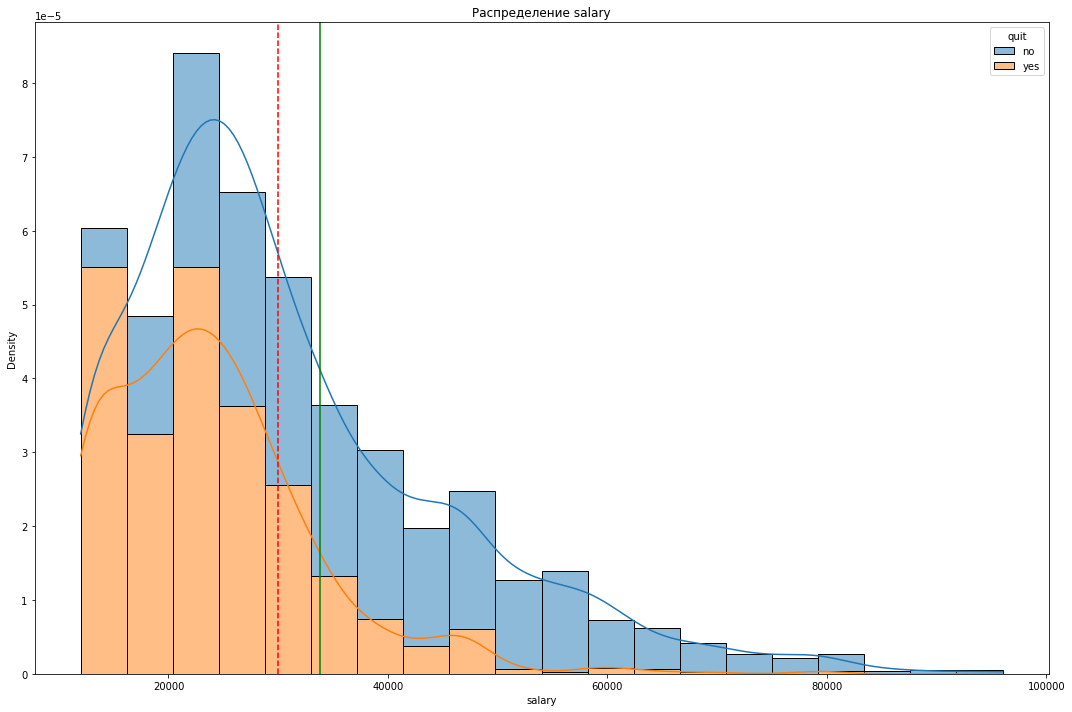

In [60]:
plt.figure(figsize=(15,10))
sns.histplot(data=train_quit, bins=20, kde=True, hue='quit',
                 x='salary', stat='density', common_norm=False, legend=True, multiple="stack")
plt.title('Распределение salary')
    
# Добавление медианы и среднего значения
median_value = train_quit['salary'].median()
mean_value = train_quit['salary'].mean()
plt.axvline(median_value, color='r', linestyle='--', label=f'Median: {median_value:.2f}')
plt.axvline(mean_value, color='g', linestyle='-', label=f'Mean: {mean_value:.2f}')


# Показать графики
plt.tight_layout()
plt.show();

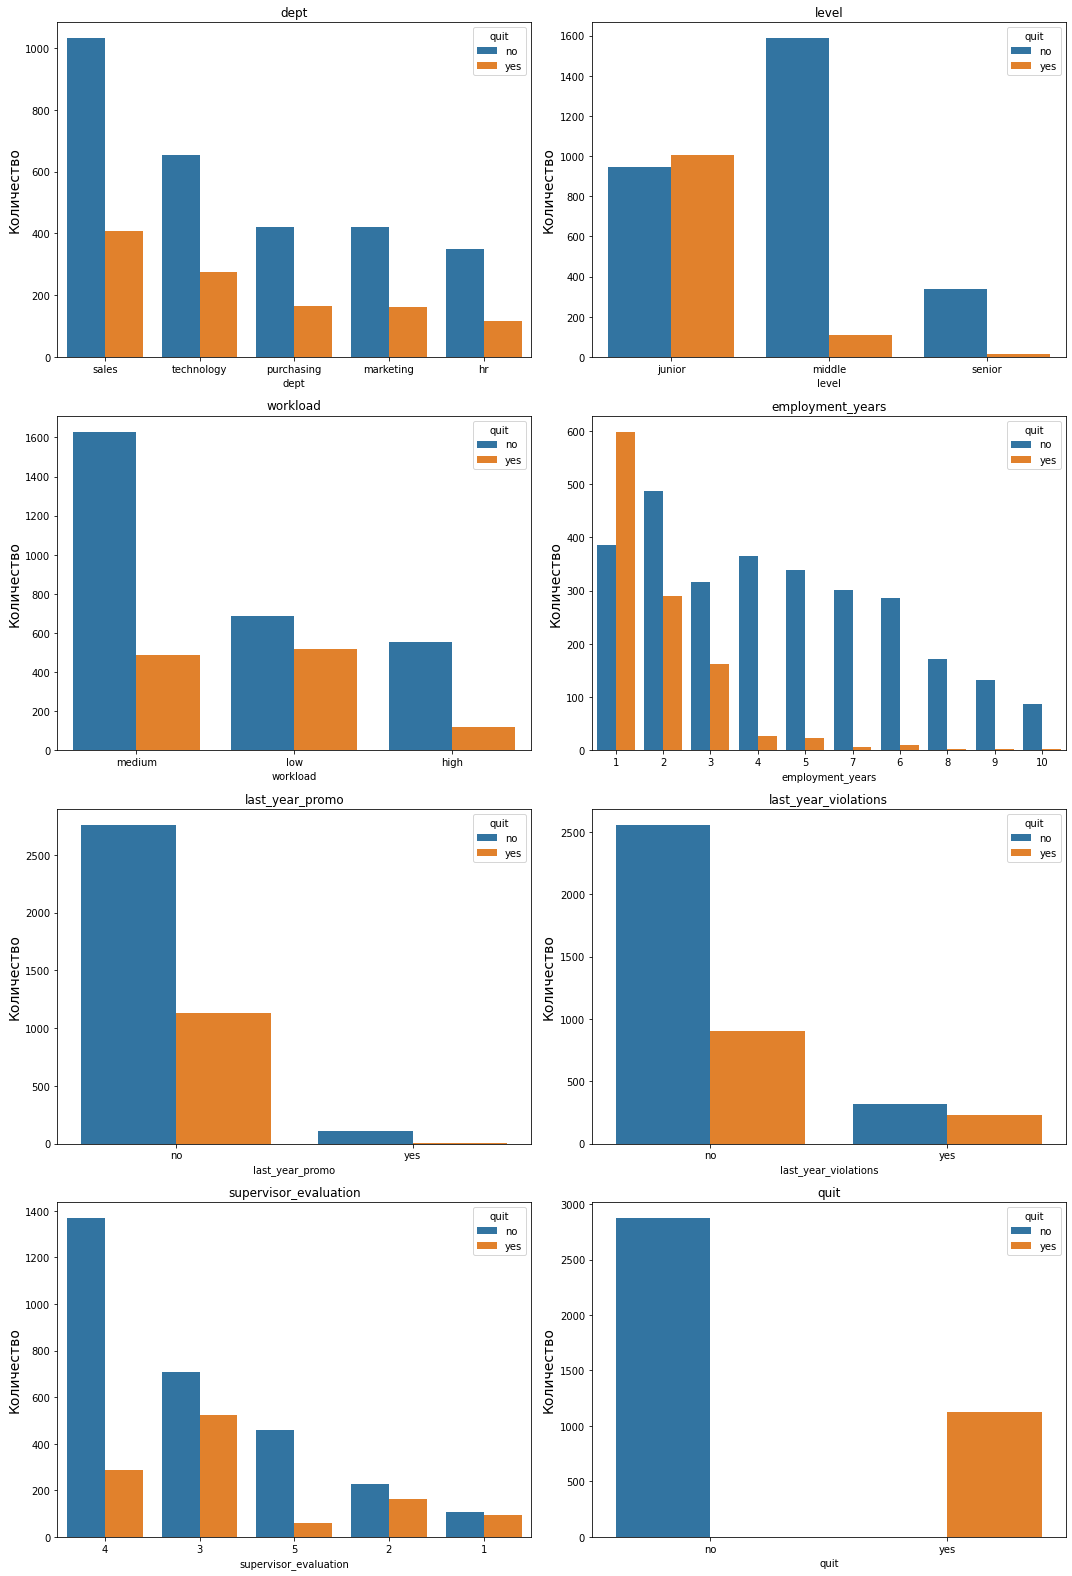

In [61]:
# Создание графика с 8 подграфиками в два столбца
fig, axes = plt.subplots(4, 2, figsize=(15, 22))

# Преобразование 2D массива подграфиков в 1D для удобного индексирования
axes = axes.ravel()

# Построение гистограмм
for i, column in enumerate([
    'dept', 'level',
    'workload', 'employment_years',
    'last_year_promo', 'last_year_violations',
    'supervisor_evaluation', 'quit'
]):
    sns.countplot(data=train_quit, ax=axes[i], 
                 x=column, order = train_quit[column].value_counts().index, hue='quit')
    axes[i].set_title(column)
    axes[i].set_ylabel('Количество', fontsize=14)
  
    
# Показать графики
plt.tight_layout()
plt.show();

In [62]:
train_grouped_dept = train_quit.groupby(['dept'])['quit'].value_counts(normalize=True)
train_grouped_dept_plt = pd.DataFrame(train_grouped_dept.loc[train_grouped_dept.index.get_level_values(1) == 'yes']).droplevel(level=1)

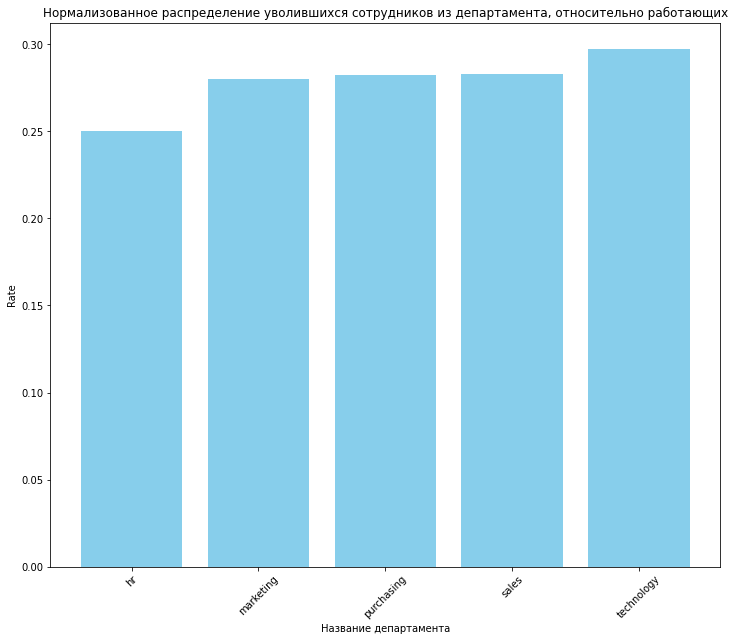

In [63]:
plt.figure(figsize=(12,10))
plt.bar(data=train_grouped_dept_plt, height=train_grouped_dept_plt['quit'], x=train_grouped_dept_plt.index, color='skyblue')
plt.xticks(rotation=45)
plt.title('Нормализованное распределение уволившихся сотрудников из департамента, относительно работающих')
plt.xlabel('Название департамента')
plt.ylabel('Rate')
plt.show()

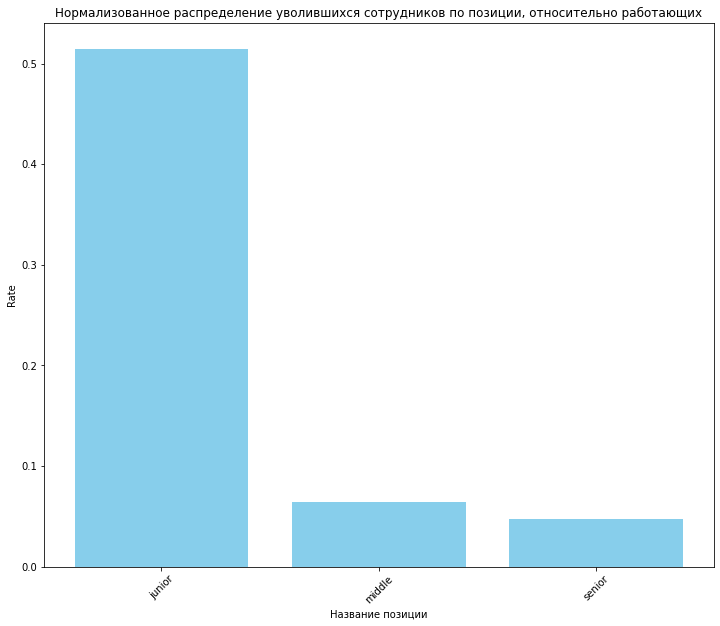

In [64]:
train_grouped = train_quit.groupby(['level'])['quit'].value_counts(normalize=True)
train_grouped_sns = pd.DataFrame(train_grouped.loc[train_grouped.index.get_level_values(1) == 'yes']).droplevel(level=1)
plt.figure(figsize=(12,10))
plt.bar(data=train_grouped_sns, height=train_grouped_sns['quit'], x=train_grouped_sns.index, color='skyblue')
plt.xticks(rotation=45)
plt.title('Нормализованное распределение уволившихся сотрудников по позиции, относительно работающих')
plt.xlabel('Название позиции')
plt.ylabel('Rate')
plt.show()

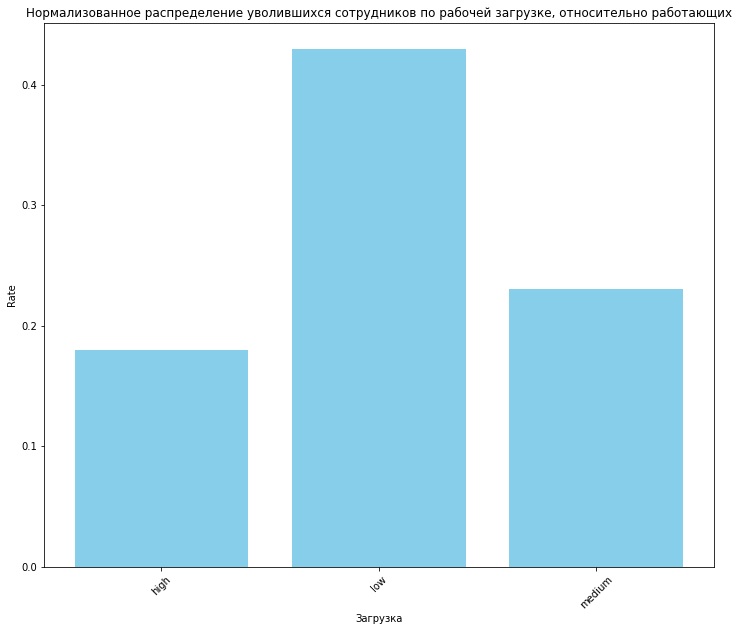

In [65]:
train_grouped_load = train_quit.groupby(['workload'])['quit'].value_counts(normalize=True)
train_grouped_load_plt = pd.DataFrame(train_grouped_load.loc[train_grouped_load.index.get_level_values(1) == 'yes']).droplevel(level=1)
plt.figure(figsize=(12,10))
plt.bar(data=train_grouped_load_plt, height=train_grouped_load_plt['quit'], x=train_grouped_load_plt.index, color='skyblue')
plt.xticks(rotation=45)
plt.title('Нормализованное распределение уволившихся сотрудников по рабочей загрузке, относительно работающих')
plt.xlabel('Загрузка')
plt.ylabel('Rate')
plt.show()

- Чаще увольняется работники из отдела `technology`, относительно работающих в департаменте.
- В основном позиция `junior`
- Имеют низкую нагрузку

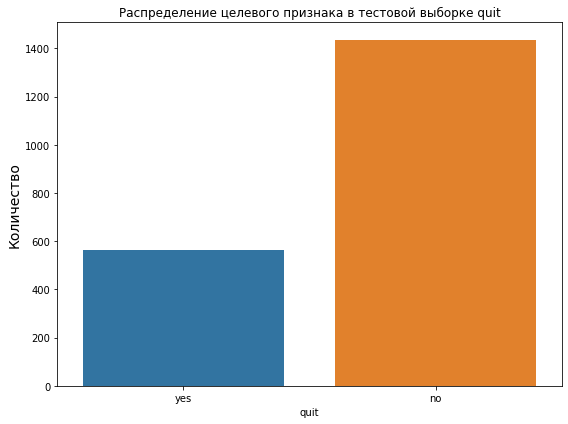

In [66]:
plt.figure(figsize=(8,6))
sns.countplot(data=test_target_quit, x='quit')
plt.title('Распределение целевого признака в тестовой выборке quit')
plt.ylabel('Количество', fontsize=14)

    
# Показать графики
plt.tight_layout()
plt.show();

<a id='Step8.2'></a>
###  Вывод по распределению данных в `train_quit` и `test_target_quit`

- Распределенные входных признаков практически идентично распределению входных признаков в Задаче 1.
- Целевой признак `quit` несбалансирован. Преобладает значение `no` - сотрудник не уволился.
- Распределение зарплаты имеет такую же характеристику как и в первой задаче - в основном сотрудники получают зарплату в размере `33000`

<a id='Step8.3'></a>
###  Портрет `уволившегося сотрудника`

По проведенному исследовательскому анализу данных уже можно сделать портрет уволившегося сотрудника.

- В основном увольняются сотрудники с младших позиций - больше всего с позиции `junior`.
- Соответственно стаж работы уволившегося сотрудника не превышает 3 года.
- Больше всего сотрудников, который уволилились получали зарплату до медианной `33000`
- Руководители оценивают таких сотрудников `удовлетворительно` - 3 балла.
- Практически все сотрудники не получили повышение, на часть сотрудников накладывались штрафные санкции.

Отдел работы не будем рассматривать как причину, потому что распределение работников по отделам неравномерное.

Дополнительно сравним средние зарплаты уволившегося сотрудника и работающего в компании.

In [67]:
mean_salary_quit = train_quit[train_quit['quit']=='yes']['salary'].mean()
mean_salary_work = train_quit[train_quit['quit']=='no']['salary'].mean()
print(f'Средняя зарплата уволившегося сотрудника равна {mean_salary_quit}')
print(f'Средняя зарплата работающего сотрудника равна {mean_salary_work}')

Средняя зарплата уволившегося сотрудника равна 23885.106382978724
Средняя зарплата работающего сотрудника равна 37702.22841225627


**ИТОГО**

**Уволившийся сотрудник это - новичок без опыта работа, с уровнем зарплаты нижесреднего.**

Сравним признак `job_satisfaction_rate` для уволившихся и оставшихся сотрудников.

In [68]:
test_target_final = test_target_quit.merge(test_target_job_satisfaction_rate, on='id', how='left')

In [69]:
test_target_final.head()

,id,quit,job_satisfaction_rate
0,999029,yes,0.35
1,372846,no,0.21
2,726767,no,0.73
3,490105,no,0.62
4,416898,yes,0.57


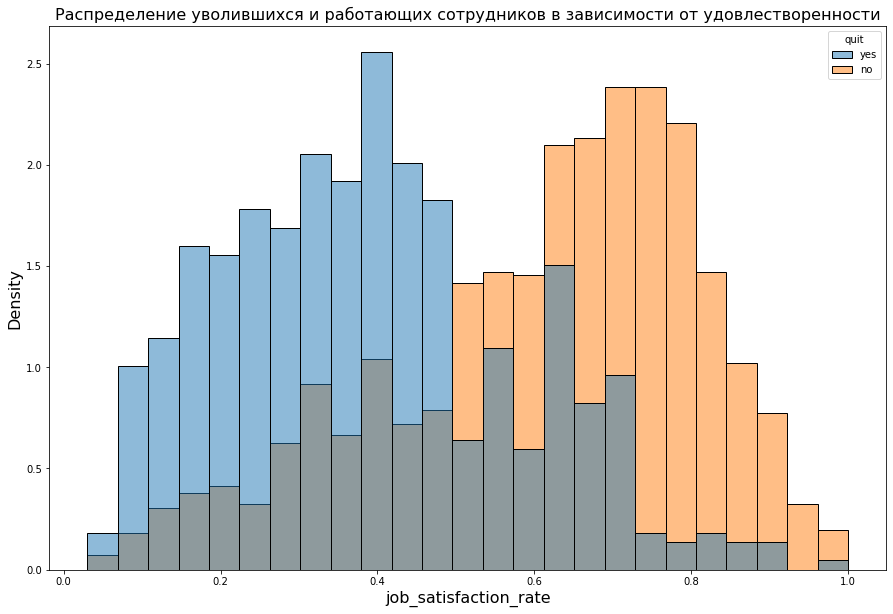

In [70]:
plt.figure(figsize=(15,10))
sns.histplot(data=test_target_final, x='job_satisfaction_rate', 
             hue='quit', stat='density', 
             bins = 25, common_norm=False
            )
plt.title('Распределение уволившихся и работающих сотрудников в зависимости от удовлестворенности', fontsize=16)
plt.xlabel('job_satisfaction_rate', fontsize=16)
plt.ylabel('Density', fontsize=16)
plt.show()

**Уволившиеся сотрудники в основном имеют удовлетворенность работой ниже 0.5**

Целевой признак удовлетворенности складывается из входных - зарплаты, должности, отдела, времени работы - логично, что если сотруднику не нравится работа - он будет искаль другой более подходящий вариант.

Уволившиеся сотрудники с высокой удовлетворенностью работой скорее всего поменяли на работу с более комфортными и привлекательными условиями, либо по какой-либо другой причине, например, переезд или семейные обстоятельства.

<a id='Step8.4'></a>
###  Вывод по разделу

**Распределение входных признаков в Задаче 2 идентичное распределению в Задаче 1:**
- В исследуемых данных один непрерывный признак `salary`. Для него построили нормализованные гистограмму распределения значений. Имеют близкое к нормальному распределению - проблем и аномалий не обнаружено.
- Распределение дискретных признаков построили при помощи `countplot()`. Тестовые и тренировочные данные имеют одинаковое соотношение распределения признаков между собой.
- Наблюдается дисбаланс во всех дискретных признаках.
- В основном сотрудники компании работают в отделе `sales`, имеют позиции `junior` и `middle` и средний уровень загруженности.
- В компании много новичков, чей стаж не превышает `3 года`.
- Из положительного в компании очень редко применяются взыскания и штрафы, но также сотрудники практически не получают повышение.
- В среднем руководитель оценивает сотрудников выше среднего.

**Портрет уволившегося сотрудника:**

По проведенному исследовательскому анализу данных уже можно сделать портрет уволившегося сотрудника.

- В основном увольняются сотрудники с младших позиций - больше всего с позиции `junior`.
- Соответственно стаж работы уволившегося сотрудника не превышает 3 года.
- Больше всего сотрудников, который уволилились получали зарплату до медианной `33000`
- Руководители оценивают таких сотрудников `удовлетворительно` - 3 балла.
- Практически все сотрудники не получили повышение, на часть сотрудников накладывались штрафные санкции.

Отдел работы не будем рассматривать как причину, потому что распределение работников по отделам неравномерное.

**Уволившийся сотрудник это - новичок без опыта работа, с уровнем зарплаты нижесреднего.**

**В основном, кто увольнялся - имеют низкий уровень удовлетворенности работой**


<a id='Step9'></a>
##  Добавление нового входного признака

Добавим `job_satisfaction_rate`, предсказанный лучшей моделью первой задачи, к входным признакам второй задачи.

In [71]:
#Добавление признака job_satisfaction_rate, предсказанный лучшей моделью первой задачи, 
#к входным признакам второй задачи в тестовые данные.
test_features_cl = test_features.join(preds, on='id', how='left')
display(test_features_cl.shape)
test_features_cl.head()

(2000, 10)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,485046,marketing,junior,medium,2,no,no,5,28800,0.872000
1,686555,hr,junior,medium,1,no,no,4,30000,0.668621
2,467458,sales,middle,low,5,no,no,4,19200,0.657143
3,418655,sales,middle,low,6,no,no,4,19200,0.655000
4,789145,hr,middle,medium,5,no,no,5,40800,0.824127


Для добавления в тренировочные данные необходимо заново предсказать значения, используя модель

In [72]:
X_test_new = train_quit.drop(['quit'], axis=1).set_index('id')
pred_cl = grid.best_estimator_.predict(X_test_new)
preds_cl = pd.DataFrame(pred_cl, columns= ['job_satisfaction_rate']).set_index(X_test_new.index)
display(preds_cl.shape)
preds_cl.head()

(4000, 1)

,job_satisfaction_rate
id,
723290,0.635385
814010,0.815937
155091,0.364091
257132,0.380000
910140,0.690000


In [73]:
#Добавим предсказанные значения в тренировочную выборку задачи 2
train_quit_cl = train_quit.join(preds_cl, on='id', how='left')
display(train_quit_cl.shape)
train_quit_cl.head()

(4000, 11)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
0,723290,sales,middle,high,2,no,no,4,54000,no,0.635385
1,814010,sales,junior,medium,2,no,no,4,27600,no,0.815937
2,155091,purchasing,middle,medium,5,no,no,1,37200,no,0.364091
3,257132,sales,junior,medium,2,no,yes,3,24000,yes,0.380000
4,910140,marketing,junior,medium,2,no,no,5,25200,no,0.690000


**Добавили целевой признак из прошлой задачи во входные признаки Задачи 2**
- В тестовую выборку добавили предсказанные значения из первой задачи
- В тренировочную выборку добавили предсказанные новые значения на основании входные признаков тренировочной выборки

<a id='Step10'></a>
##  Подготовка данных

Подготовим признаки так же, как и в первой задаче: 
- Выполним подготовку в пайплайне, дополнив пайплайн предобработки. 
- При кодировании учитываем особенности признаков и моделей и используем как минимум два кодировщика.

Будем использовать модели `KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression() и SVC().`

- Подготовим данные перед созданием пайплайнов.

1. Разобьем данные на тренировочную и тестовую выборки;
2. Разобьем данные на количественные и категориальные, при этом категориальные данные поделим на две группы для кодирования с помощью OneHotEncoder и OrdinalEncoder;
3. Соберем пайплайн для кодирования категориальных данных с помощью OneHotEncoder;
4. Соберем пайплайн для кодирования категориальных данных с помощью OrdinalEncoder;
5. Объединим все пайплайны вместе с масштабированием количественных данных в один общий пайплайн.

<a id='Step10.1'></a>
###  Разделение данных на выборки

In [74]:
#Добавим целевой признак к входным тестовой выборки
test_features_cl = test_features_cl.merge(test_target_quit, on='id', how='left')

In [75]:
#Отделим входные признаки от целевого признака
train_quit_cl_not_ind = train_quit_cl.set_index('id')
X_train_cl = train_quit_cl_not_ind.drop('quit', axis=1)
y_train_cl = train_quit_cl_not_ind['quit']

test_features_cl_not_ind = test_features_cl.set_index('id')
X_test_cl = test_features_cl_not_ind.drop('quit', axis=1)
y_test_cl = test_features_cl_not_ind['quit']

X_train_cl.shape, X_test_cl.shape

((4000, 9), (2000, 9))

<a id='Step10.2'></a>
###  Создание пайплайна

In [76]:
X_train_cl.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,0.635385
814010,sales,junior,medium,2,no,no,4,27600,0.815937
155091,purchasing,middle,medium,5,no,no,1,37200,0.364091
257132,sales,junior,medium,2,no,yes,3,24000,0.380000
910140,marketing,junior,medium,2,no,no,5,25200,0.690000


In [77]:
#Созадим списки с распределением столбов для кодирования

num_columns_cl = ['employment_years', 'salary', 'job_satisfaction_rate']
ohe_columns_cl = ['last_year_promo', 'last_year_violations', 'dept']
ord_columns_cl = ['level', 'workload', 'supervisor_evaluation']

In [78]:
# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe_cl = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='infrequent_if_exist', sparse_output=False)
        )
    ]
)

In [79]:
# cоздаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
# SimpleImputer + OE
ord_pipe_cl = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',
            OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'senior'], 
                    ['low', 'medium', 'high'],
                    [1, 2, 3, 4, 5]
                ],
                handle_unknown='use_encoded_value',
                unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

In [80]:
# создаём общий пайплайн для подготовки данных с использованием ColumnTransformer
data_preprocessor_cl = ColumnTransformer(
    [
        ('ohe', ohe_pipe_cl, ohe_columns_cl),
        ('ord', ord_pipe_cl, ord_columns_cl),
        ('num', MinMaxScaler(), num_columns_cl)
    ], 
    remainder='passthrough'
)

In [81]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final_cl= Pipeline(
    [
        ('preprocessor', data_preprocessor_cl),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

<a id='Step10.3'></a>
###  Создание алгоритма поиска оптимальных гиперпараметров

In [82]:
param_distributions_cl = [
    # словарь для модели KNeighborsClassifier() 
    {
        # название модели
        'models': [KNeighborsClassifier()],
        # указываем гиперпараметр модели n_neighbors
        'models__n_neighbors': range(2, 6),
        # указываем список методов масштабирования
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']   
    },
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 15), 
        'models__max_features': range(2, 15),
        #'models__min_samples_split': range(2, 10),
        #'models__min_samples_leaf': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
     # словарь для модели SVC()
    {
        'models': [SVC(kernel='rbf', random_state=RANDOM_STATE, probability=True)],
        'models__degree': range(2, 3),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  

    },
    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE,
                                      solver='liblinear',
                                      penalty='l1'
                                     )],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    }
] 

LabelEncoder лучше применять только к целевому признаку. 
К признакам для построения модели нужно применять другие кодировщики

In [83]:
#Закодируем целевой признак при помощи LabelEncoder()

label_encoder = LabelEncoder()
y_train_cl = label_encoder.fit_transform(y_train_cl)
y_test_cl = label_encoder.transform(y_test_cl)

In [84]:
label_encoder.classes_

array(['no', 'yes'], dtype=object)

**`no` (уволился) соответствует значению `0`**

**`yes`(не уволился) соответствует значению `1`**

<a id='Step10.4'></a>
###  Вывод по разделу

- Создали финальный пайплайн из нескольких.
- Подготовили входные признаки при помощи OneHotEncoder() и OrdinalEncoder(), а также количественные признаки закодировали StandardScaler(), MinMaxScaler()
- Целевой признак закодировали при помощи LabelEncoder().
- В алгорит поиска лучшей модели включили 4 модели: `KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression() и SVC().`

<a id='Step11'></a>
##  Обучение моделей

**Настраиваем инструмент поиска лучшей модели.**

Возьмем `GridSearchCV` - выборка имеет небольшое количество признаков, а также строк. 

Выберем лучшую модель и проверим её качество на основе метрики —  ROC-AUC. Критерий успеха: ROC-AUC ≥ 0.91 на тестовой выборке. 

Используем метрику `roc-auc`, так как важны как precision, так и recall, но подбор порога актуален не для всех моделей и важнее получить общее понимание о работе модели.

ROC-AUC: Чаще используется в задачах бинарной классификации для оценки способности модели разделять классы, независимо от баланса классов.

In [85]:
grid_cl = GridSearchCV(
    pipe_final_cl, 
    param_grid=param_distributions_cl, 
    cv=5, 
    scoring='roc_auc',
    n_jobs=-1,
    error_score= 'raise'
)

<a id='Step11.1'></a>
###  Обучение алгоритма поиска оптимальных гиперпараметров

In [86]:
grid_cl.fit(X_train_cl, y_train_cl)

GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('simpleImputer_ohe',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='infrequent_if_exist',
                                                                                                        sparse_output=False))]),
                                                                         ['last_year_promo',
                                                                          'last_year_viol...
                                                'passthrough']},
                         {'models': [SVC(probability=True, random_state=42)],
                          'models__degree': range(2, 3),
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(), RobustScaler(),
                                                'passthrough']},
                         {'models': [LogisticRegression(penalty='l1',
                                                        random_state=42,
                                                        solver='liblinear')],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(), RobustScaler(),
                                                'passthrough']}],
             scoring='roc_auc')

In [87]:
print('Лучшая модель и её параметры:\n\n', grid_cl.best_estimator_)
#print ('Метрика лучшей модели на тренировочной выборке:', grid.best_score_)
print ('Метрика лучшей модели на кросс-валидации:', grid_cl.best_score_.round(2))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='infrequent_if_exist',
                                                                                 sparse_output=False))]),
                                                  ['last_year_promo',
                                                   'last_year_violations',
                                                   'dept']),
                     

In [90]:
pd.set_option('display.max_colwidth', None)
gs_multiscoring_results_cl = pd.DataFrame(
    grid_cl.cv_results_
)
gs_multiscoring_results_cl.sort_values(by='rank_test_score')[['rank_test_score', 
                        'mean_test_score', 
                        'params']].head(10)

,rank_test_score,mean_test_score,params
694,1,0.929192,"{'models': SVC(probability=True, random_state=42), 'models__degree': 2, 'preprocessor__num': RobustScaler()}"
191,2,0.928980,"{'models': DecisionTreeClassifier(random_state=42), 'models__max_depth': 5, 'models__max_features': 6, 'preprocessor__num': 'passthrough'}"
188,2,0.928980,"{'models': DecisionTreeClassifier(random_state=42), 'models__max_depth': 5, 'models__max_features': 6, 'preprocessor__num': StandardScaler()}"
190,2,0.928980,"{'models': DecisionTreeClassifier(random_state=42), 'models__max_depth': 5, 'models__max_features': 6, 'preprocessor__num': RobustScaler()}"
189,2,0.928980,"{'models': DecisionTreeClassifier(random_state=42), 'models__max_depth': 5, 'models__max_features': 6, 'preprocessor__num': MinMaxScaler()}"
692,6,0.928261,"{'models': SVC(probability=True, random_state=42), 'models__degree': 2, 'preprocessor__num': StandardScaler()}"
201,7,0.927945,"{'models': DecisionTreeClassifier(random_state=42), 'models__max_depth': 5, 'models__max_features': 9, 'preprocessor__num': MinMaxScaler()}"
200,7,0.927945,"{'models': DecisionTreeClassifier(random_state=42), 'models__max_depth': 5, 'models__max_features': 9, 'preprocessor__num': StandardScaler()}"
202,7,0.927945,"{'models': DecisionTreeClassifier(random_state=42), 'models__max_depth': 5, 'models__max_features': 9, 'preprocessor__num': RobustScaler()}"
203,7,0.927945,"{'models': DecisionTreeClassifier(random_state=42), 'models__max_depth': 5, 'models__max_features': 9, 'preprocessor__num': 'passthrough'}"


- Топ-1 и топ-6 модель метод опорных векторов `SVC()`
- Остальными уверенно занимает место DecisionTreeClassifier()

In [91]:
# проверим работу модели на тестовой выборке
# рассчитем прогноз на тестовых данных
pred_cl = grid_cl.predict_proba(X_test_cl)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test_cl, pred_cl[:,1]).round(2)}')

Метрика ROC-AUC на тестовой выборке: 0.93


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


<a id='Step11.2'></a>
###  Проверка модели на адекватность

Модели, обученные на несбалансированных данных, склонны гораздо лучше предсказывать мажорный класс и игнорировать остальные. 

Чтобы узнать, не предвзята ли ваша модель, сравним её с такой, которая всегда присваивает объектам мажорный класс.

In [92]:
# создание и обучение модели DummyClassifier 
dummy_model_cl = DummyClassifier(random_state=RANDOM_STATE)
dummy_model_cl.fit(X_train_cl, y_train_cl)

DummyClassifier(random_state=42)

In [93]:
# предсказание на тестовых данных
dummy_model_preds_cl = dummy_model_cl.predict(X_test_cl)
dummy_model_probas_cl = dummy_model_cl.predict_proba(X_test_cl)[:,1]

In [94]:
# посчитаем и выведем метрику ROC-AUC
dummy_roc_cl = roc_auc_score(y_test_cl, dummy_model_probas_cl)
print('ROC-AUC =', round(dummy_roc_cl,2))

ROC-AUC = 0.5


**ROC-AUC после проверки модели на адекватность показала значение `0.5`, что сильно ниже полученного значения лучшей модели `0.93`**

<a id='Step11.3'></a>
###  Вывод по разделу

- Для обучения моделей взяли `GridSearchCV`, чтобы перебрать все варианты. Объем данных небольшой, что позволяет рассмотреть все возможные варианты.
- Обучили модели и получили лучшую модель `SVC` с гиперпараметром `degree=2` и кодировщиком количественных признаков `RobustScaler`
- **Метрика ROC-AUC лучшей модели на кросс-валидации: 0.93**
- **Метрика ROC-AUC на тестовой выборке: 0.93**
- Провели проверку модели на адекватность. Проверка показала значение SMAPE = `0.5`, что существенно меньше, чем на тестовой выборке.

**ПРОМЕЖУТОЧНЫЕ ВЫВОДЫ**

Лучшей моделью стала `SVC` - метод опорный векторов. Бывает, что выбросы удалить невозможно. Тогда используют другие модели классификации, например метод опорных векторов. Принцип работы метода такой — максимизировать расстояние между классами, проводя разделяющую прямую или гиперплоскость.

<a id='StepFinal'></a>
#  Общий вывод

- Первая задача — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. 
Почему бизнесу это важно: удовлетворённость работой напрямую влияет на отток сотрудников. А предсказание оттока — одна из важнейших задач HR-аналитиков. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник.
- Вторая задача — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

В ходе решения первой задачи провели:
- Загрузку данных
- Предобработку данных:
    1. Убрали опечатки 
    2. Отсортировали данные согласно `id`
- Исследовательский анализ, в котором рассмотрели распределение данных и зависимости.
- Подготовили данные - создали пайплайн, в котором убрали пропуски данных, применили 2 кодировщика категориальных признаков и 3 кодировщика числовых признаков.
- Создали алгоритм обучения модели - использовали 4 модели с подбором лучших гиперпараметров.
- Получили лучшую модель для задачи регрессии - `DecisionTreeRegressor()` - получили `значения удовлетворенности работой сотрудников компании`.
- Проверили модель на адекватность и получили предсказанные значения для тестовой выборки.

В ходе решения второй задачи провели:
- Загрузку данных
- Предобработку данных:
    1. Убрали опечатки 
    2. Отсортировали данные согласно `id`
- Исследовательский анализ, в котором рассмотрели распределение данных и зависимости.
- Подготовили данные - создали пайплайн, в котором убрали пропуски данных, применили 2 кодировщика категориальных признаков и 4 кодировщика числовых признаков.
- Создали алгоритм обучения модели - использовали 4 модели с подбором лучших гиперпараметров.
- Получили лучшую модель для задачи регрессии - `SVC()` - получили предсказание `увольнения сотрудника`.
- Проверили модель на адекватность и получили предсказанные значения для тестовой выборки.   

Также составили портрет уволившегося сотрудника: 

**Уволившийся сотрудник это - новичок без опыта работа, с уровнем зарплаты нижесреднего.**

**В основном, кто увольнялся - имеют низкий уровень удовлетворенности работой**